In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import sklearn
import scipy
import statsmodels
import xlrd
import openpyxl
import lxml
import html5lib
from bs4 import BeautifulSoup
import tensorflow
import keras
from fbprophet import Prophet
import pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose


C:\Users\berka\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\berka\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\berka\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\berka\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


### Procedure

Our case study is multivariate timeseries (ts) data. Due to time limit and showing our general approach to this model, we
start from general univariate models and increase model complexity after each iteration. here is whole scenario:

**Univariate statsmodels**

**Multivariate statsmodels**

**Facebook fbprophet tool**

**Deep learning models (lstm,gru,rnn)**

**Automl time series approach**

**Feature engineering and refit models (if i have time)**


### About our data:

Data frequency is hourly and our time range is 9 months (273 days to be precise) however our target column frequency is daily thus i will use aggregation (downsample) to our data to make it daily as well. This will cause more general model with less noise to pick so our model become more simple, however it makes our prediction process much more faster. we will down from 6552 observations to 273 observations and lose some seasonality effect. If i have enough time i will also check for hourly case as well.

my prediction horizon (forecast) will be 1 month because thats what our company does on "middle term (ortavade)" from coding
standpoint forecasting for 1 month vs 1 year is same just horizon range is different.

i will use 8 month as training set and 1 month as test set on every occasion. then make test set evaluation depending on our model prediction. i will use rmse as an evaluation metric and compare it with overall test set mean.

Because our data is multivariate and dynamic, most of the predictions are off by large margin (my assumption) however this case study is created for my whole time series domain knowledge thus it will be better to see all models and how they fit to data.

I'will start with Brent Spot Price first, i will continue onward to Gas Spot Price if i have time also. Data starts from 01-10-2018 and ends with 30-06-2019. starting with eda.

In [2]:
brent_train=pd.read_excel("Jr_Analyst_Case_Study_Brent_Train.xlsx")
brent_test=pd.read_excel("Jr_Analyst_Case_Study_Brent_Test.xlsx")

In [3]:
print(brent_train.shape)
brent_train.head()
#243 day in train.

(5832, 12)


,Date,Date-Time,Germany Price [€/MWh],Czech Republic Price [€/MWh],Germany - Czech Power Flow [MWh],Germany Wind Generation [MWh],Germany Solar Generation [MWh],Germany Lignite Generation [MWh],Czech Wind Generation [MWh],Czech Solar Generation [MWh],Czech Lignite Generation [MWh],Target(Brent)
0,2018-10-01 00:00:00,0-1,59.53,43.92,-1564,5785.330467,0.0,15980.419518,68.371420,0.0,4828.822731,84.94
1,2018-10-01 01:00:00,1-2,56.10,41.52,-1806,5957.379407,0.0,16042.222953,62.263001,0.0,4832.868665,84.94
2,2018-10-01 02:00:00,2-3,51.41,37.50,-1931,5935.688423,0.0,16124.285607,50.581991,0.0,4766.110747,84.94
3,2018-10-01 03:00:00,3-4,47.38,35.14,-1906,6253.412038,0.0,16193.525971,50.046165,0.0,4774.202616,84.94
4,2018-10-01 04:00:00,4-5,47.59,39.81,-1615,7043.407528,0.0,16255.329406,45.223729,0.0,4859.167239,84.94


In [4]:
print(brent_test.shape)
brent_test.head()
#30 day in test.

(720, 12)


,Date,Date-Time,Germany Price [€/MWh],Czech Republic Price [€/MWh],Germany - Czech Power Flow [MWh],Germany Wind Generation [MWh],Germany Solar Generation [MWh],Germany Lignite Generation [MWh],Czech Wind Generation [MWh],Czech Solar Generation [MWh],Czech Lignite Generation [MWh],Target(Brent)
0,2019-06-01 00:00:00,0-1,33.63,36.92,-408,5043.982059,0.000000,9594.972082,15.842449,0.00000,2600.367871,66.78
1,2019-06-01 01:00:00,1-2,31.03,32.50,-959,5068.756037,0.000000,8995.144799,13.824303,0.00000,2553.879742,66.78
2,2019-06-01 02:00:00,2-3,28.23,29.30,-909,5575.383901,0.000000,8376.698716,12.613415,0.00000,2466.838140,66.78
3,2019-06-01 03:00:00,3-4,27.62,28.30,-1151,6393.172937,0.000000,8121.570836,13.319766,0.00000,2521.239141,66.78
4,2019-06-01 04:00:00,4-5,25.53,26.27,-1565,7352.421392,1.767535,7179.560203,16.548801,5.55366,2520.250032,66.78


In [5]:
#start off, lets turn our data into daily freq (from hourly freq)
brent_train.index=pd.to_datetime(brent_train["Date"])
brent_train_daily=brent_train.resample("D").mean()

brent_test.index=pd.to_datetime(brent_test["Date"])
brent_test_daily=brent_test.resample("D").mean()

In [6]:
#to able to plot both tr and test easily, lets join 2 df
brent_df=brent_train_daily.append(brent_test_daily)

# Univariate Approximations

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


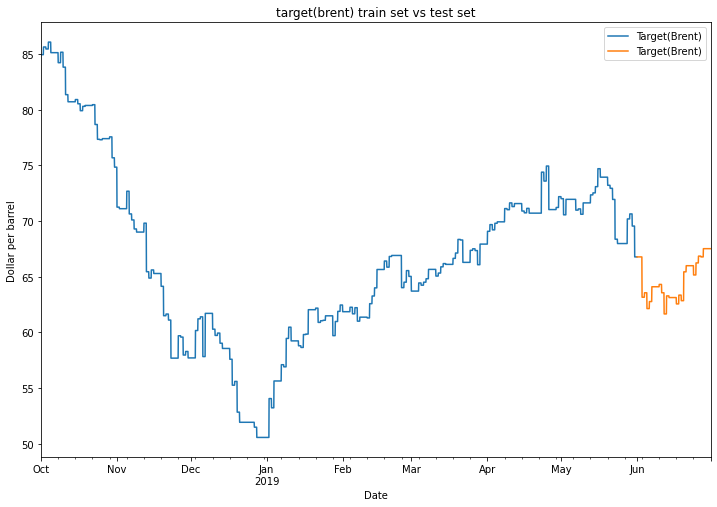

In [7]:
title="target(brent) train set vs test set"
ylabel="Dollar per barrel"
xlabel="Date"
#we just use patterns, components in target col for prediction and forecasting. most basic format.
ax=brent_train[["Target(Brent)"]].plot(figsize=(12,8),title=title,legend=True)
ax.autoscale(axis="x",tight=True)
ax.set(xlabel=xlabel,ylabel=ylabel)
brent_test[["Target(Brent)"]].plot(figsize=(12,8),ax=ax,legend=True)
#its has some seasonality and downward trend overall.

In [8]:
#trend : upward,downward,stationary(stable)
#seasonality: repeating pattern
#cyclical:trends w no set of repetition

#hodrick prescott filter separates ts into trend and cyclical component. for quarterly data lambda parameter=1600, 
#6.25 for annual and 129600 for monthly.


#In general you use smoothing functions to remove the noise, not the trend (which in general is what we want to identify or
#study). I think the best is by trial and error. Smooth with increasing smoothing parameters and check the data by eye, once
#you don't have that many short spikes but a quite "smooth" curve, than it's done. Be careful to don't smooth too much,
#otherwise you will remove interesting signals. important issue is also what method to use for smoothing,

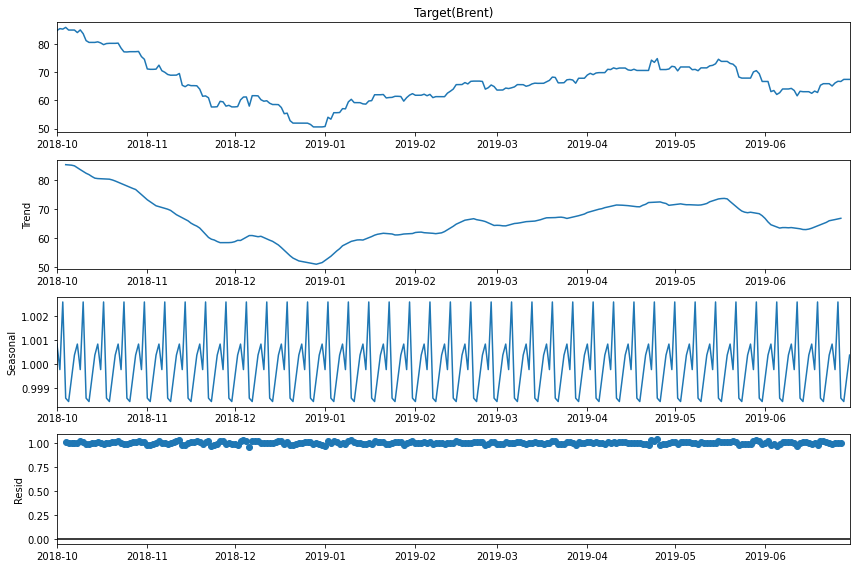

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
%matplotlib inline
result = seasonal_decompose(brent_df['Target(Brent)'], model='multiplicative')  # model='mul' also works

plt.rcParams['figure.figsize'] = [12, 8]
result.plot();

#our data range is btw 50-85 and our seasonality effect is btw 0.999 - 1.002
#we set our model as multiplicative bcs our trend looks non-linear.we re increasing /decreasing at non-linear rate.

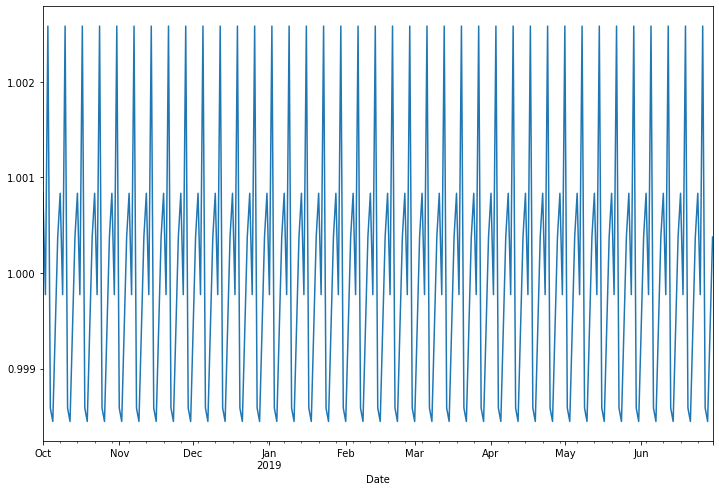

In [10]:
result.seasonal.plot()
#273 days, 39 peaks which means our seasonality is weekly.  its also very low, peak=1.002 and valley is 0.999.
#we could disable seasonality for computational purposes as well, however our data is quite small for faster predictions
#thats why most of the time we make seasoanlity available.

### Simple Moving Average (SMA) and EWMA (Exponentially Weighted Moving Average )

In [11]:
brent_df_target=brent_df[["Target(Brent)"]]
brent_df_target.head()

,Target(Brent)
Date,
2018-10-01,84.94
2018-10-02,85.63
2018-10-03,85.45
2018-10-04,86.07
2018-10-05,85.12


In [12]:
# ax=brent_train[["Target(Brent)"]].plot(figsize=(12,8),title=title,legend=True)
# ax.autoscale(axis="x",tight=True)
# ax.set(xlabel=xlabel,ylabel=ylabel)
# brent_test[["Target(Brent)"]].plot(figsize=(12,8),ax=ax,legend=True)

brent_df_target["sma7"]=brent_df_target["Target(Brent)"].rolling(window=7).mean()
brent_df_target["sma30"]=brent_df_target["Target(Brent)"].rolling(window=30).mean()
#we wont use this for pred, just show how it catches the patterns in data

C:\Users\berka\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\berka\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.
[Full details on Mathematics behind this can be found here](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows).
Here is the shorter version of the explanation behind EWMA.

The formula for EWMA is:
### $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}

* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

In [13]:
brent_df_target["ewma7"]=brent_df_target["Target(Brent)"].ewm(span=7,adjust=False).mean()
brent_df_target["ewma30"]=brent_df_target["Target(Brent)"].ewm(span=30,adjust=False).mean()

C:\Users\berka\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\berka\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
brent_df_target.columns

Index(['Target(Brent)', 'sma7', 'sma30', 'ewma7', 'ewma30'], dtype='object')

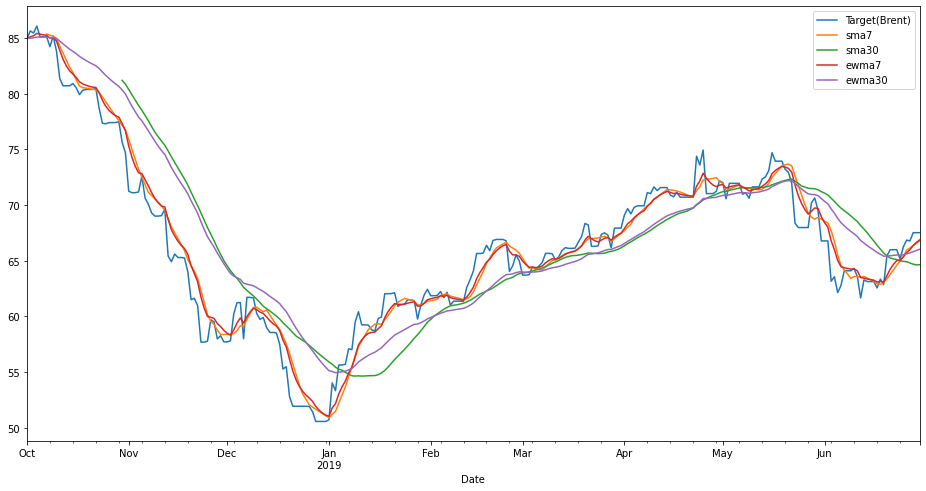

In [15]:
brent_df_target[["Target(Brent)","sma7","sma30","ewma7","ewma30"]].plot(figsize=(16,8));

#result: for given reasons, ewma is advanced form of sma, recent vals have more weight, u can also see seasonality effect
#more clearly overall.

## Holt-Winters Methods (1st Univariate TS Forecast Model)
In the previous section on <strong>Exponentially Weighted Moving Averages</strong> (EWMA) we applied <em>Simple Exponential Smoothing</em> using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality.

In this section we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In <strong>Double Exponential Smoothing</strong> (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.

In [80]:
#basically one smoothing factor in ewma wasnt enough, it fails to detect contributing factors like trend and seasoanlity.
#level : average value in the series. we use "alpha" smoothing factor for level, just like in ewma
#trend : we use "beta" smoothing factor for trend. this is new. and it creates "double exponential smoothing" aka holts methd
#seasonal : we use "gamma" smoothing factor for seaonality. this is new and it creates "triple exp smoothing" aka h-w methd

#why exponential? bcs recent values have increasing weights.
#we will use holt-winters methods for forecasting as well.

**Basic Forecasting procedure:**

1)Choose a model

2)split data into tr and test sets

3)fit a model on tr set

4)eval model on test set

5)refit model on entire dset

6)forecast for future

we wont do last 2 parts, we just make forecast for 1 month then compare it with our test set 1 month via rmse

In [ ]:
#bcs we have seasonality it will be good idea to choose holt-winters method rather than holt method

In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model = ExponentialSmoothing(brent_train_daily['Target(Brent)'],
                                    trend='mul',
                                    seasonal='mul',
                                    seasonal_periods=7).fit()

#mul vs add for seasonality : if seasonal variations are constant, choose "add" if seasonality change proportional to level
#of the series then choose "mul"

#our seasonality could be additive. we may be check for 2 cases.
#how to find seasonal periods : our data is daily and our seasonal cycle is weekly so seasonal periods is 7

C:\Users\berka\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning:

invalid value encountered in less_equal

C:\Users\berka\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal



In [19]:
test_predictions = fitted_model.forecast(30).rename('HW Forecast')

In [20]:
test_predictions

2019-06-01    66.745276
2019-06-02    66.598559
2019-06-03    66.623595
2019-06-04    66.710182
2019-06-05    66.544745
2019-06-06    65.923991
2019-06-07    65.682787
2019-06-08    65.511921
2019-06-09    65.367915
2019-06-10    65.392488
2019-06-11    65.477475
2019-06-12    65.315095
2019-06-13    64.705811
2019-06-14    64.469065
2019-06-15    64.301356
2019-06-16    64.160011
2019-06-17    64.184130
2019-06-18    64.267547
2019-06-19    64.108167
2019-06-20    63.510142
2019-06-21    63.277771
2019-06-22    63.113160
2019-06-23    62.974427
2019-06-24    62.998101
2019-06-25    63.079976
2019-06-26    62.923541
2019-06-27    62.336567
2019-06-28    62.108490
2019-06-29    61.946921
2019-06-30    61.810751
Freq: D, Name: HW Forecast, dtype: float64

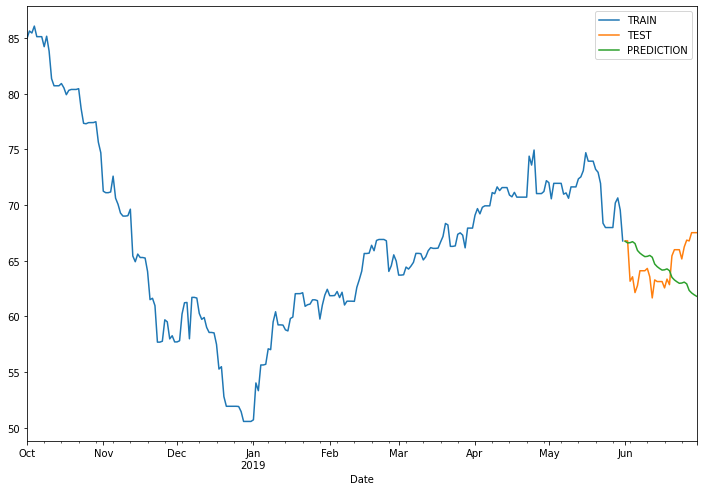

In [21]:
brent_train_daily['Target(Brent)'].plot(legend=True,label='TRAIN')
brent_test_daily['Target(Brent)'].plot(legend=True,label='TEST',figsize=(12,8));
test_predictions.plot(legend=True,label='PREDICTION');

#not a good prediction.

In [22]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [23]:
np.sqrt(mean_absolute_error(brent_test_daily["Target(Brent)"],test_predictions))

1.5810608047106025

In [24]:
brent_test_daily["Target(Brent)"].describe()
#64.6 mean and 1.8 std, our model rmse is 1.6 it looks not bad however it you see the visual test and pred goes opposite
#directions.

count    30.000000
mean     64.648333
std       1.804789
min      61.660000
25%      63.137500
50%      64.100000
75%      66.177500
max      67.520000
Name: Target(Brent), dtype: float64

In [25]:
#i will add our first model result
results_df=pd.DataFrame()
results_df["holt_winters_rmse"]=[np.sqrt(mean_absolute_error(brent_test_daily["Target(Brent)"],test_predictions)),]
results_df
#we dont just use rmse as a metric, we will also use plot results, and how prediction vs test set patterns match.
#so 1.58 could be good however its not a good model in terms of pattern match btw test and predictions

,holt_winters_rmse
0,1.581061


## Introduction to ARIMA Models
We'll investigate a variety of different forecasting models in upcoming sections, but they all stem from ARIMA.

<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<strong>Moving Averages</strong> we've already seen with EWMA and the Holt-Winters Method.<br>
<strong>Integration</strong> will apply differencing to make a time series stationary, which ARIMA requires.<br>
<strong>Autoregression</strong> is explained in detail in the next section. Here we're going to correlate a current time series with a lagged version of the same series.<br>
Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

### Autocorrelation Function / Partial Autocorrelation Function
Before we can investigate <em>autoregression</em> as a modeling tool, we need to look at <em>covariance</em> and <em>correlation</em> as they relate to lagged (shifted) samples of a time series.


### Goals
 * Be able to create ACF and PACF charts
 * Create these charts for multiple times series, one with seasonality and another without
 * Be able to calculate Orders PQD terms for ARIMA off these charts (highlight where they cross the x axis)

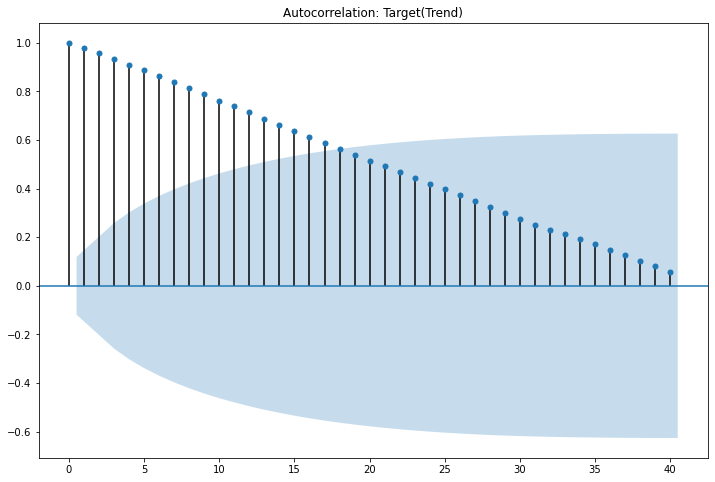

In [26]:
# acf and pacf used for calculating p and q order of arima based models. ofc p and q u get from here prone to human error
# thus we wont use this approach in real life.

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

title = 'Autocorrelation: Target(Trend)'
lags = 40
plot_acf(brent_df[["Target(Brent)"]],title=title,lags=lags);

#comment about acf : u see gradual decline here, its very common for seasonal data. if u have much more stronger seasonality
#u can see peaks and valleys on autocorr plot. autocorr is correlation btw data and its lagged format. as lag increases 
#correlation will decrease.

#blue curve is conf interval. its boundaries are increasing bcs further away u get from actual time you will get much more
#noise and u need to increase yr conf interval ranges because of that. if autocorr values are within conf interval range, 
#they are not statistically significant from 0, so for ex after lag=18 yr current data and lagged parts arent correlated.

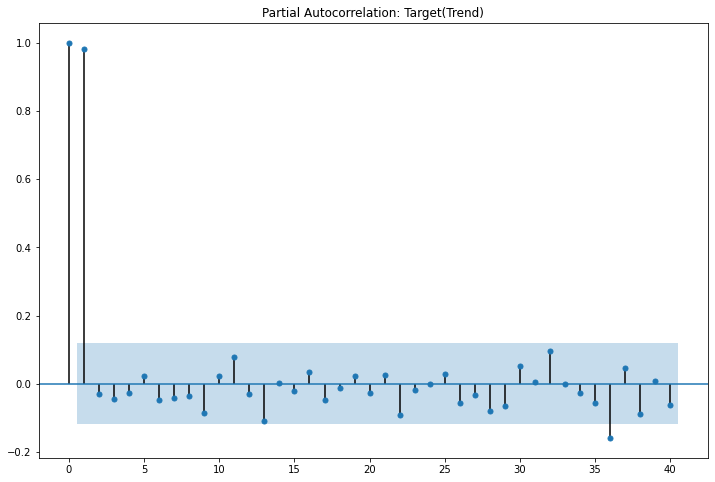

In [27]:
title = 'Partial Autocorrelation: Target(Trend)'
lags = 40
plot_pacf(brent_df[["Target(Brent)"]],title=title,lags=lags);

#https://people.duke.edu/~rnau/411arim3.html in this link u can see how to decide p and q coefs via acf,pacf
#if pacf has a gradual decline then it suggest ma model. also if there is a sharp drop after lag-k it suggest ar(k) model

## AR(p) Autoregressive Model (2nd Univariate TS Model)
In a moving average model as we saw with Holt-Winters, we forecast the variable of interest using a linear combination of predictors. In our example we forecasted numbers of airline passengers in thousands based on a set of level, trend and seasonal predictors.

In an autoregression model, we forecast using a linear combination of <em>past values</em> of the variable. The term <em>autoregression</em> describes a regression of the variable against itself. An autoregression is run against a set of <em>lagged values</em> of order $p$.

### $y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}$

where $c$ is a constant, $\phi_{1}$ and $\phi_{2}$ are lag coefficients up to order $p$, and $\varepsilon_{t}$ is white noise.

For example, an <strong>AR(1)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$

whereas an <strong>AR(2)</strong> model would follow the formula

&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$

and so on.

Note that the lag coeffients are usually less than one, as we usually restrict autoregressive models to stationary data.<br>
Specifically, for an <strong>AR(1)</strong> model: $-1 \lt \phi_1 \lt 1$<br>
and for an <strong>AR(2)</strong> model: $-1 \lt \phi_2 \lt 1, \ \phi_1 + \phi_2 \lt 1, \ \phi_2 - \phi_1 \lt 1$<br>

Models <strong>AR(3)</strong> and higher become mathematically very complex. Fortunately statsmodels does all the heavy lifting for us.

In [28]:
import warnings
warnings.filterwarnings("ignore")

In [29]:
#WE let statsmodels to choose "p" value
from statsmodels.tsa.ar_model import AR,ARResults
model=AR(brent_train_daily["Target(Brent)"])
ARfit = model.fit(method='mle',maxiter=1000)
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 15
Coefficients:
const                0.772521
L1.Target(Brent)     0.986813
L2.Target(Brent)     0.058709
L3.Target(Brent)    -0.098672
L4.Target(Brent)     0.048879
L5.Target(Brent)     0.046119
L6.Target(Brent)     0.021379
L7.Target(Brent)     0.013342
L8.Target(Brent)     0.017813
L9.Target(Brent)    -0.101586
L10.Target(Brent)   -0.015202
L11.Target(Brent)    0.040354
L12.Target(Brent)    0.066889
L13.Target(Brent)   -0.148378
L14.Target(Brent)    0.041977
L15.Target(Brent)    0.010428
dtype: float64


In [30]:
start = len(brent_train_daily["Target(Brent)"])
end = len(brent_train_daily["Target(Brent)"])+len(brent_test_daily["Target(Brent)"])-1
rename = f'AR(15) Predictions'

predictions15 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)

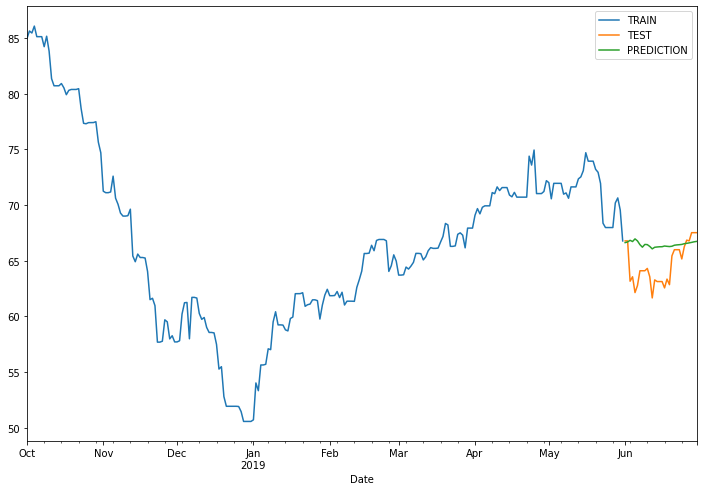

In [31]:
brent_train_daily['Target(Brent)'].plot(legend=True,label='TRAIN')
brent_test_daily['Target(Brent)'].plot(legend=True,label='TEST',figsize=(12,8));
predictions15.plot(legend=True,label='PREDICTION');

In [32]:
np.sqrt(mean_absolute_error(brent_test_daily["Target(Brent)"],predictions15))

1.4271568271161397

We see right away how well AR(15) performed

Another method is the <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike information criterion</a> (AIC), which does a better job of evaluating models by avoiding overfitting.<br>

these models are used just to see how they detect / capture the pattern, so i wont deal with details too much

In [33]:
results_df["ar15_rmse"]=np.sqrt(mean_absolute_error(brent_test_daily["Target(Brent)"],predictions15))

In [34]:
results_df

,holt_winters_rmse,ar15_rmse
0,1.581061,1.427157


## Augmented Dickey-Fuller Test (Stationarity Test)
To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

To demonstrate, we'll use a dataset we know is <em>not</em> stationary, the airline_passenger dataset. First, let's plot the data along with a 12-month rolling mean and standard deviation:

In [35]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [36]:
adf_test(brent_train_daily["Target(Brent)"])

#its non stationary, its not very important to check if this data is stationary but its important for some other ts models
#wehere u need to apply differencing and check if data becomes stationary or not

#stationary data has no trend or no seasonality or both.

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.321997
p-value                   0.164971
# lags used               0.000000
# observations          242.000000
critical value (1%)      -3.457664
critical value (5%)      -2.873559
critical value (10%)     -2.573175
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


# Granger Causality Tests
The <a href='https://en.wikipedia.org/wiki/Granger_causality'>Granger causality test</a> is a a hypothesis test to determine if one time series is useful in forecasting another. Basically u could test if 2 time series correlated or not. If they are  then there are some models (VAR,VARMA) that uses multiple ts data to predict one another.

In [37]:
from statsmodels.tsa.stattools import grangercausalitytests,adfuller

Essentially we're looking for extremely low p-values.

In [38]:
grangercausalitytests(brent_train_daily[["Czech Republic Price [€/MWh]","Target(Brent)"]],10)
#for example, up to 10 lag, there is no case where we can reject null and say there is a correlation btw 2 cols.
#these cols are not correlated for any lagged case. not good for var/varma models.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0120  , p=0.9129  , df_denom=239, df_num=1
ssr based chi2 test:   chi2=0.0122  , p=0.9122  , df=1
likelihood ratio test: chi2=0.0122  , p=0.9122  , df=1
parameter F test:         F=0.0120  , p=0.9129  , df_denom=239, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0007  , p=0.9993  , df_denom=236, df_num=2
ssr based chi2 test:   chi2=0.0015  , p=0.9992  , df=2
likelihood ratio test: chi2=0.0015  , p=0.9992  , df=2
parameter F test:         F=0.0007  , p=0.9993  , df_denom=236, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1216  , p=0.9473  , df_denom=233, df_num=3
ssr based chi2 test:   chi2=0.3758  , p=0.9452  , df=3
likelihood ratio test: chi2=0.3756  , p=0.9452  , df=3
parameter F test:         F=0.1216  , p=0.9473  , df_denom=233, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1806  , p=0.9483  

{1: ({'ssr_ftest': (0.011999808084177494, 0.9128632346387602, 239.0, 1),
   'ssr_chi2test': (0.012150433290255036, 0.9122277606768885, 1),
   'lrtest': (0.012150128273333394, 0.9122288579189374, 1),
   'params_ftest': (0.011999808084243703, 0.9128632346383763, 239.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.0007410753053853084, 0.9992592015484563, 236.0, 2),
   'ssr_chi2test': (0.0015135521067615196, 0.9992435102293948, 2),
   'lrtest': (0.0015135473538521182, 0.9992435126040518, 2),
   'params_ftest': (0.0007410753053901354, 0.9992592015484563, 236.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.12162815462443315, 0.9472975627437492, 233.0, 3),
   'ssr_chi2test': (0.37584665806691786, 0.9451855476819345, 3),
   'lrtest': (0.375552671807327, 0.9452451242322221, 3),
   'params_ftest': (0.12162815462446112, 0.9472975627437334, 233.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
 

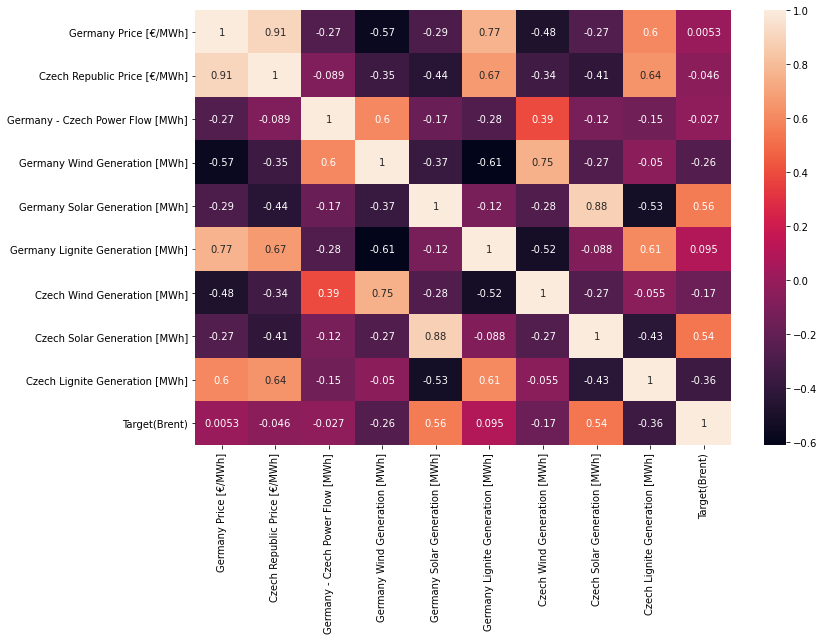

In [39]:
import seaborn as sn
sn.heatmap(brent_train_daily.corr(),annot=True)
#its similar to this approach however this cant show u lagged version comparison ofc.

## Arima Based Models and PmdArima

This is a third-party tool separate from statsmodels. It should already be installed if you're using our virtual environment. If not, then at a terminal run:<br>
&nbsp;&nbsp;&nbsp;&nbsp;<tt>pip install pmdarima</tt>

In [40]:
from pmdarima import auto_arima
help(auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, exogenous=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=False, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arim

In [41]:
model=auto_arima(brent_train_daily["Target(Brent)"], start_p=1, start_q=1,
                          max_p=6, max_q=6, m=7,
                          start_P=0, seasonal=True,
                          d=None, D=1, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,
                maxiter=200)           # set to stepwise

model.summary()

#AR-I-MA : AR is autoregression part with parameter p, MA is moving average part w parameter q and I is differencing part w d

#MA uses dependency btw observations and a residual error from moving average applied to lagged observations

#AR is a regression model that uses dependent rship btw current obs & its lagged counterparts. works well w lineartrend data

#ARIMA and SARIMA is powerful statsmodels tool in terms of "Univariate" approach. due to I in the formula, it doenst need
#stationary data to run. it could work with non stationary data as well. Differencing makes ns->s. Stationary data has const
#mean and std thus this values will be same for future and make it easier to pred for models. thats why ns->s

#information criterion is aic by default, it punishes complex models to deal w model overfitting. lower aic is better

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=727.023, Time=0.43 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=847.904, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=795.748, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=726.328, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=847.801, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=728.300, Time=0.14 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=728.291, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=795.749, Time=0.04 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=729.591, Time=0.35 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=724.371, Time=0.06 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=726.334, Time=0.08 sec
 ARIMA(0,1,0)(0,1,2)[7]             : AIC=726.323, Time=0.20 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=793.874, Time=0.02 sec
 ARIMA(0,1,0)(1,1,2)[7]             : AIC=727.705, Time=0.26 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=726.3

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  243
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -360.186
Date:                             Tue, 20 Oct 2020   AIC                            724.371
Time:                                     19:44:06   BIC                            731.290
Sample:                                          0   HQIC                           727.161
                                             - 243                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.8753      0.042    -20.649      0.000      -0.958      -0.792
sigma2         1.2023      0.071     17.025      0.000       1.064       1.341
===================================================================================
Ljung-Box (Q):                       30.56   Jarque-Bera (JB):                93.25
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.15
Prob(H) (two-sided):                  0.35   Kurtosis:                         6.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
auto_arima(brent_train_daily["Target(Brent)"], start_p=1, start_q=1,
                          max_p=6, max_q=6, m=7,
                          start_P=0, seasonal=False,
                          d=None, D=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True,
                maxiter=200).summary()

#btw sarimax (we dont use another col for predicting target so its sarima to be precise, univaritate) and arima, sarimax
#has better aic results. its understandable bcs our data has seasonality in itself as well. lets train our data w sarimax.

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=731.190, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=889.710, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=813.429, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=729.435, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=887.732, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=731.201, Time=0.09 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=732.399, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=727.726, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=729.438, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=729.450, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=811.468, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=730.666, Time=0.08 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.684 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  243
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -361.863
Date:                Tue, 20 Oct 2020   AIC                            727.726
Time:                        19:44:10   BIC                            734.696
Sample:                             0   HQIC                           730.534
                                - 243                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9687      0.021    -45.887      0.000      -1.010      -0.927
sigma2         1.1661      0.064     18.159      0.000       1.040       1.292
===================================================================================
Ljung-Box (Q):                       38.14   Jarque-Bera (JB):               126.40
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.30
Prob(H) (two-sided):                  0.15   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [44]:
model = SARIMAX(brent_train_daily["Target(Brent)"],order=(0,1,0),seasonal_order=(0,1,1,7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       Target(Brent)   No. Observations:                  243
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 7)   Log Likelihood                -360.186
Date:                             Tue, 20 Oct 2020   AIC                            724.371
Time:                                     19:44:16   BIC                            731.290
Sample:                                 10-01-2018   HQIC                           727.161
                                      - 05-31-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L7       -0.8753      0.042    -20.649      0.000      -0.958      -0.792
sigma2         1.2023      0.071     17.025      0.000       1.064       1.341
===================================================================================
Ljung-Box (Q):                       30.56   Jarque-Bera (JB):                93.25
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.15
Prob(H) (two-sided):                  0.35   Kurtosis:                         6.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
start=len(brent_train_daily["Target(Brent)"])
end=len(brent_train_daily["Target(Brent)"])+len(brent_test_daily["Target(Brent)"])-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,0)(0,1,1,7) Predictions')


Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

In [46]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:.2f}, expected={brent_test_daily['Target(Brent)'][i]:.2f}")

predicted=66.78, expected=66.78
predicted=66.78, expected=66.78
predicted=66.86, expected=63.16
predicted=67.36, expected=63.56
predicted=67.50, expected=62.14
predicted=66.96, expected=62.77
predicted=66.49, expected=64.10
predicted=66.49, expected=64.10
predicted=66.49, expected=64.10
predicted=66.58, expected=64.31
predicted=67.07, expected=63.56
predicted=67.21, expected=61.66
predicted=66.67, expected=63.28
predicted=66.20, expected=63.13
predicted=66.20, expected=63.13
predicted=66.20, expected=63.13
predicted=66.29, expected=62.56
predicted=66.78, expected=63.35
predicted=66.92, expected=62.85
predicted=66.39, expected=65.44
predicted=65.92, expected=65.99
predicted=65.92, expected=65.99
predicted=65.92, expected=65.99
predicted=66.00, expected=65.16
predicted=66.49, expected=66.24
predicted=66.63, expected=66.85
predicted=66.10, expected=66.78
predicted=65.63, expected=67.52
predicted=65.63, expected=67.52
predicted=65.63, expected=67.52


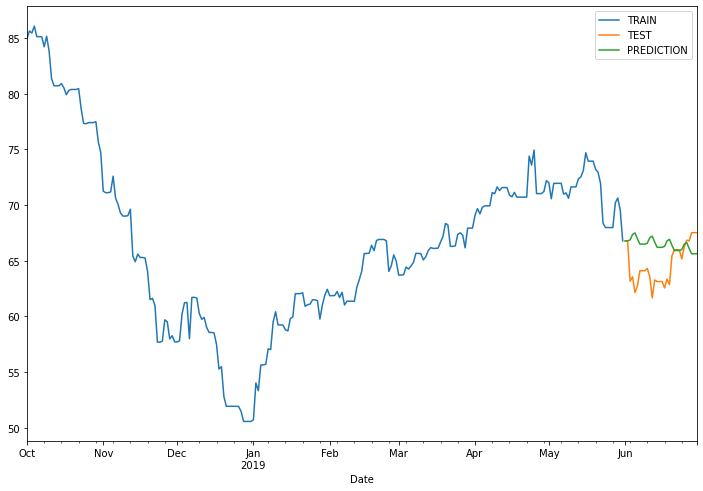

In [47]:
brent_train_daily['Target(Brent)'].plot(legend=True,label='TRAIN')
brent_test_daily['Target(Brent)'].plot(legend=True,label='TEST',figsize=(12,8));
predictions.plot(legend=True,label='PREDICTION');

#now we move onto multivariate cases bcs as u can see univariate cases are pretty problematic for prediction
#in terms of "stock type" dynamic data, it could be good for predicting how many passengers airplane firm gets etc.

In [48]:
np.sqrt(mean_absolute_error(brent_test_daily["Target(Brent)"],predictions))

1.5081902120024329

In [49]:
results_df["sarima0100117_rmse"]=np.sqrt(mean_absolute_error(brent_test_daily["Target(Brent)"],predictions))

In [50]:
results_df

,holt_winters_rmse,ar15_rmse,sarima0100117_rmse
0,1.581061,1.427157,1.50819


# Multivariate statsmodels tools (SARIMAX, VAR, VARMAX)

In [213]:
#prevly it was 1 time-dependent variable which is our target "target(brent)" for multivariate cases, we will use other cols
#bcs this cols have some correlation with target col which is important for better model efficiency. starting w sarimax

#here is my multivariate ts approach:
#i will add scaled and stdscaled and normal data to pmdarima 
#i will create corr matrix and add 1-2 cols that are most corr w our target(brent) and run var model (need stationary data)

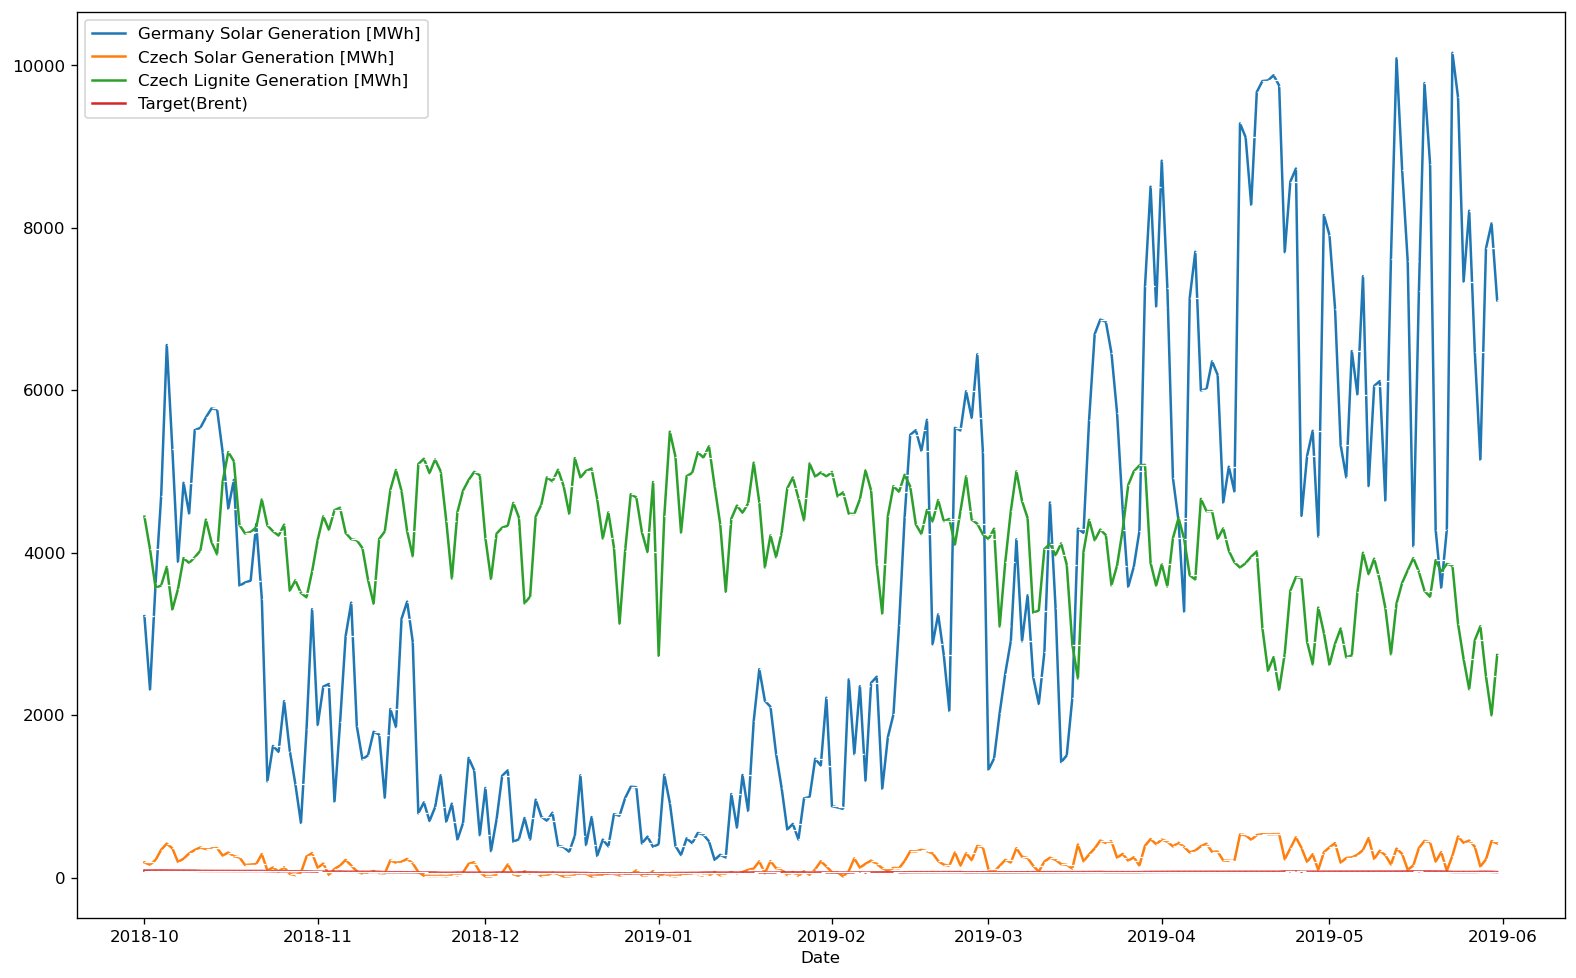

In [53]:
import seaborn as sns
#sns.lineplot(data=brent_df,marker="o")
from matplotlib.pyplot import figure
figure(num=None, figsize=(16, 10), dpi=120, facecolor='w', edgecolor='k')
sns.lineplot(data=brent_train_daily[["Germany Solar Generation [MWh]","Czech Solar Generation [MWh]",
                                             "Czech Lignite Generation [MWh]","Target(Brent)"]], marker = True, dashes=False)
#im planning to make 1-2 stationary column and add run var model. thats why i run this lineplot and corr matrix above.
#i could use germany solar generation and czech solar generation, make them stationary via differencing and add to var model

In [54]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [55]:
brent_train_daily_scaled=brent_train_daily.copy()
brent_test_daily_scaled=brent_test_daily.copy()

In [56]:
brent_train_daily_stdscaled=brent_train_daily.copy()
brent_test_daily_stdscaled=brent_test_daily.copy()

In [57]:
scaler = MinMaxScaler()
brent_train_daily_scaled=scaler.fit_transform(brent_train_daily_scaled.iloc[:,0:-1])
brent_test_daily_scaled=scaler.transform(brent_test_daily_scaled.iloc[:,0:-1])

In [58]:
scaler = StandardScaler()
brent_train_daily_stdscaled=scaler.fit_transform(brent_train_daily_stdscaled.iloc[:,0:-1])
brent_test_daily_stdscaled=scaler.transform(brent_test_daily_stdscaled.iloc[:,0:-1])

In [59]:
brent_train_daily_scaled=pd.DataFrame(data=brent_train_daily_scaled,columns=brent_train_daily.columns[0:9],
            index=brent_train_daily.index).join(brent_train_daily["Target(Brent)"])

In [60]:
brent_test_daily_scaled=pd.DataFrame(data=brent_test_daily_scaled,columns=brent_test_daily.columns[0:9],
            index=brent_test_daily.index).join(brent_test_daily["Target(Brent)"])

In [61]:
brent_train_daily_stdscaled=pd.DataFrame(data=brent_train_daily_stdscaled,columns=brent_train_daily.columns[0:9],
            index=brent_train_daily.index).join(brent_train_daily["Target(Brent)"])

In [62]:
brent_test_daily_stdscaled=pd.DataFrame(data=brent_test_daily_stdscaled,columns=brent_test_daily.columns[0:9],
            index=brent_test_daily.index).join(brent_test_daily["Target(Brent)"])

## SARIMAX (1st Multivariate TS Model)

In [63]:
auto_arima(brent_train_daily_scaled["Target(Brent)"],
           exog=brent_train_daily_scaled.iloc[:,0:-1],start_p=0,start_q=0,max_p=7,max_q=7,m=7,start_P=0,seasonal=True,d=None,
           D=None,trace=True,error_action='ignore', suppress_warnings=True,stepwise=True,maxiter=1000,
           scoring="mse").summary()

#error action: we don't want to know if an order does not work
#suppress_warnings: we don't want convergence warnings
#trace: prints out training procedure while model training

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,1)[7]             : AIC=889.720, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=887.732, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=813.178, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=729.013, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=727.726, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=729.042, Time=0.07 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=730.210, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[7]             : AIC=729.438, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[7]             : AIC=729.450, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=811.468, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[7]             : AIC=730.666, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[7] intercept   : AIC=729.435, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[7]          
Total fit time: 0.609 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  243
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -361.863
Date:                Tue, 20 Oct 2020   AIC                            727.726
Time:                        19:46:53   BIC                            734.696
Sample:                             0   HQIC                           730.534
                                - 243                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9687      0.021    -45.887      0.000      -1.010      -0.927
sigma2         1.1661      0.064     18.159      0.000       1.040       1.292
===================================================================================
Ljung-Box (Q):                       38.14   Jarque-Bera (JB):               126.40
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.30
Prob(H) (two-sided):                  0.15   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
auto_arima(brent_train_daily_stdscaled["Target(Brent)"],
           exog=brent_train_daily_stdscaled.iloc[:,0:-1],start_p=0,start_q=0,max_p=7,max_q=7,m=7,start_P=0,seasonal=True,
           d=None,
           D=None,trace=True,error_action='ignore', suppress_warnings=True,stepwise=True,maxiter=1000,
           scoring="mse").summary()

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,1)[7]             : AIC=889.720, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=887.732, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=813.178, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=729.013, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=727.726, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=729.042, Time=0.07 sec
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=730.210, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[7]             : AIC=729.438, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[7]             : AIC=729.450, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=811.468, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[7]             : AIC=730.666, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[7] intercept   : AIC=729.435, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[7]          
Total fit time: 0.605 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  243
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -361.863
Date:                Tue, 20 Oct 2020   AIC                            727.726
Time:                        19:46:57   BIC                            734.696
Sample:                             0   HQIC                           730.534
                                - 243                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9687      0.021    -45.887      0.000      -1.010      -0.927
sigma2         1.1661      0.064     18.159      0.000       1.040       1.292
===================================================================================
Ljung-Box (Q):                       38.14   Jarque-Bera (JB):               126.40
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                            -0.30
Prob(H) (two-sided):                  0.15   Kurtosis:                         6.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [65]:
model = SARIMAX(endog=brent_train_daily_scaled['Target(Brent)'],
                exog=brent_train_daily_scaled.iloc[:,0:-1],order=(0,2,1),seasonal_order=(0,0,0,7),enforce_invertibility=True,
               maxiter=1000)
results = model.fit()
results.summary()

#comments:
#data format for "exog" has to be df, even if u add just one time dependent variable like "Germany Price" for ex.
#enforce_invertibility=False (sts it cause an error) basically if u turn it to True it adds more weights to current variable.
#just like ewma. make it True first then if there is no "valueerror" u can keep it true.
#

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Target(Brent)   No. Observations:                  243
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -358.401
Date:                Tue, 20 Oct 2020   AIC                            738.802
Time:                        19:47:05   BIC                            777.134
Sample:                    10-01-2018   HQIC                           754.245
                         - 05-31-2019                                         
Covariance Type:                  opg                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Germany Price [€/MWh]                0.7996      1.817      0.440      0.660      -2.762       4.361
Czech Republic Price [€/MWh]         1.3143      1.520      0.864      0.387      -1.666       4.294
Germany - Czech Power Flow [MWh]     0.4488      0.620      0.724      0.469      -0.767       1.664
Germany Wind Generation [MWh]        0.3399      0.823      0.413      0.680      -1.274       1.954
Germany Solar Generation [MWh]       0.2925      0.548      0.534      0.594      -0.782       1.367
Germany Lignite Generation [MWh]    -0.0152      0.969     -0.016      0.987      -1.915       1.884
Czech Wind Generation [MWh]         -0.2478      0.422     -0.587      0.557      -1.075       0.579
Czech Solar Generation [MWh]        -0.1203      0.460     -0.262      0.793      -1.021       0.780
Czech Lignite Generation [MWh]      -0.9053      1.092     -0.829      0.407      -3.045       1.234
ma.L1                               -0.9680      0.023    -41.627      0.000      -1.014      -0.922
sigma2                               1.1331      0.072     15.766      0.000       0.992       1.274
===================================================================================
Ljung-Box (Q):                       42.73   Jarque-Bera (JB):               110.63
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.37
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
start=len(brent_train_daily_scaled["Target(Brent)"])
end=len(brent_train_daily_scaled["Target(Brent)"])+len(brent_test_daily_scaled["Target(Brent)"])-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels',
                              exog=brent_test_daily_scaled.iloc[:,0:-1]).rename('SARIMAX(0,2,1)(0,0,0,7) Predictions')

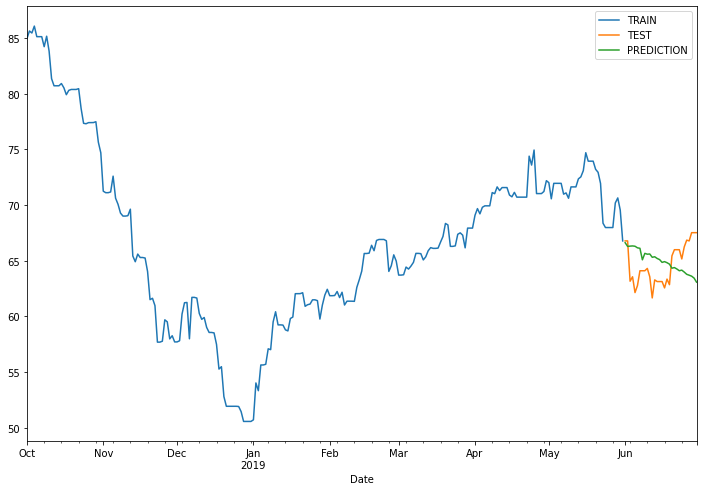

In [67]:
brent_train_daily['Target(Brent)'].plot(legend=True,label='TRAIN')
brent_test_daily['Target(Brent)'].plot(legend=True,label='TEST',figsize=(12,8));
predictions.plot(legend=True,label='PREDICTION');

#minmaxscaled version

In [68]:
np.sqrt(mean_absolute_error(brent_test_daily["Target(Brent)"],predictions))

1.498391337904999

In [69]:
results_df["sarimax0210007_scaled_rmse"]=np.sqrt(mean_absolute_error(brent_test_daily["Target(Brent)"],predictions))
results_df

#prev sarimax0210007_rmse model has rmse value of 3.44 now it becomes 1.5, minmaxscaler works on some degree.

,holt_winters_rmse,ar15_rmse,sarima0100117_rmse,sarimax0210007_scaled_rmse
0,1.581061,1.427157,1.50819,1.498391


In [70]:
model = SARIMAX(endog=brent_train_daily_stdscaled['Target(Brent)'],
                exog=brent_train_daily_stdscaled.iloc[:,0:-1],order=(0,2,1),seasonal_order=(0,0,0,7),
                enforce_invertibility=True,
               maxiter=1000)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Target(Brent)   No. Observations:                  243
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -358.401
Date:                Tue, 20 Oct 2020   AIC                            738.802
Time:                        19:47:21   BIC                            777.134
Sample:                    10-01-2018   HQIC                           754.245
                         - 05-31-2019                                         
Covariance Type:                  opg                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Germany Price [€/MWh]                0.1188      0.270      0.440      0.660      -0.410       0.648
Czech Republic Price [€/MWh]         0.2140      0.247      0.866      0.387      -0.271       0.699
Germany - Czech Power Flow [MWh]     0.0777      0.108      0.722      0.470      -0.133       0.289
Germany Wind Generation [MWh]        0.0830      0.201      0.413      0.679      -0.311       0.477
Germany Solar Generation [MWh]       0.0815      0.152      0.536      0.592      -0.216       0.379
Germany Lignite Generation [MWh]    -0.0036      0.251     -0.015      0.988      -0.496       0.489
Czech Wind Generation [MWh]         -0.0620      0.106     -0.586      0.558      -0.269       0.145
Czech Solar Generation [MWh]        -0.0341      0.129     -0.263      0.792      -0.288       0.220
Czech Lignite Generation [MWh]      -0.1804      0.217     -0.832      0.405      -0.605       0.244
ma.L1                               -0.9680      0.023    -41.630      0.000      -1.014      -0.922
sigma2                               1.1331      0.072     15.767      0.000       0.992       1.274
===================================================================================
Ljung-Box (Q):                       42.74   Jarque-Bera (JB):               110.62
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                            -0.37
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [71]:
start=len(brent_train_daily_scaled["Target(Brent)"])
end=len(brent_train_daily_scaled["Target(Brent)"])+len(brent_test_daily_scaled["Target(Brent)"])-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels',
                              exog=brent_test_daily_stdscaled.iloc[:,0:-1]).rename('SARIMAX(0,2,1)(0,0,0,7) Predictions')


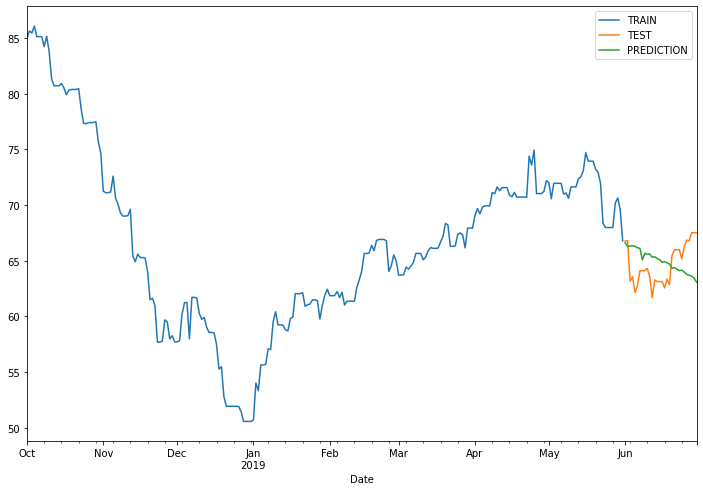

In [72]:
brent_train_daily['Target(Brent)'].plot(legend=True,label='TRAIN')
brent_test_daily['Target(Brent)'].plot(legend=True,label='TEST',figsize=(12,8));
predictions.plot(legend=True,label='PREDICTION');

#results:
#other time dependent cols isnt correlated enough thus rather than adding help they ll cause more noise, worse ts predictions

In [73]:
np.sqrt(mean_absolute_error(brent_test_daily["Target(Brent)"],predictions))

1.498418516932576

In [74]:
results_df["sarimax0210007_stdscaled_rmse"]=np.sqrt(mean_absolute_error(brent_test_daily["Target(Brent)"],predictions))
results_df
#there is very small dif btw minmaxscaled and stdscaled models.

,holt_winters_rmse,ar15_rmse,sarima0100117_rmse,sarimax0210007_scaled_rmse,sarimax0210007_stdscaled_rmse
0,1.581061,1.427157,1.50819,1.498391,1.498419


## VAR (2nd Multivariate TS Model)

We'll fit a series of models using the first seven p-values, and base our final selection on the model that provides the lowest AIC and BIC scores.

In [386]:
var_brent=brent_df[["Target(Brent)","Germany Solar Generation [MWh]"]]

In [388]:
adf_test(var_brent["Target(Brent)"])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.465859
p-value                   0.124004
# lags used               0.000000
# observations          272.000000
critical value (1%)      -3.454622
critical value (5%)      -2.872225
critical value (10%)     -2.572464
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [389]:
adf_test(var_brent["Germany Solar Generation [MWh]"])

Augmented Dickey-Fuller Test: 
ADF test statistic       -0.312602
p-value                   0.923700
# lags used              12.000000
# observations          260.000000
critical value (1%)      -3.455754
critical value (5%)      -2.872721
critical value (10%)     -2.572728
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [390]:
var_brent1=var_brent.diff().dropna()

In [391]:
adf_test(var_brent1["Target(Brent)"])

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.667995e+01
p-value                 1.519382e-29
# lags used             0.000000e+00
# observations          2.710000e+02
critical value (1%)    -3.454713e+00
critical value (5%)    -2.872265e+00
critical value (10%)   -2.572485e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [392]:
adf_test(var_brent1["Germany Solar Generation [MWh]"])
#both becomes stationary. good.var model needs stationary data.

Augmented Dickey-Fuller Test: 
ADF test statistic       -5.622225
p-value                   0.000001
# lags used              11.000000
# observations          260.000000
critical value (1%)      -3.455754
critical value (5%)      -2.872721
critical value (10%)     -2.572728
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [394]:
nobs=30
train, test = var_brent1[0:-30], var_brent1[-30:]

In [396]:
from statsmodels.tsa.api import VAR
for i in [1,2,3,4,5,6,7]:
    model = VAR(train)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()
    
#var doesnt have pmdarima

Order = 1
AIC:  14.494964344056534
BIC:  14.581722773935969

Order = 2
AIC:  14.472083789190075
BIC:  14.61711041099599

Order = 3
AIC:  14.462101838432968
BIC:  14.665744054864103

Order = 4
AIC:  14.414224142002142
BIC:  14.676832848414271

Order = 5
AIC:  14.45151170380758
BIC:  14.773441337161895

Order = 6
AIC:  14.4719495851465
BIC:  14.853558173835763

Order = 7
AIC:  14.471130790250893
BIC:  14.912780004822487



In [397]:
results = model.fit(4)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 20, Oct, 2020
Time:                     23:29:31
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.6768
Nobs:                     238.000    HQIC:                   14.5201
Log likelihood:          -2372.71    FPE:                1.81991e+06
AIC:                      14.4142    Det(Omega_mle):     1.68970e+06
--------------------------------------------------------------------
Results for equation Target(Brent)
                                       coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------------
const                                    -0.077465         0.071371           -1.085           0.278
L1.Target(Brent)                          0.000632         0.066514      

In [398]:
lag_order = results.k_ar
lag_order

4

In [399]:
z = results.forecast(y=train.values[-lag_order:], steps=30)
z

array([[-8.82387217e-04, -3.23347597e+02],
       [ 5.60449266e-02, -5.09688716e+02],
       [-3.66613088e-02,  4.73945649e+02],
       [-1.90193221e-01,  4.59020456e+02],
       [-1.62019488e-01, -2.28553773e+01],
       [-8.85549873e-02, -9.92072032e+01],
       [ 1.88300975e-03, -1.75371473e+02],
       [-4.53693705e-02, -2.99798592e+01],
       [-8.32906381e-02,  1.06096294e+02],
       [-1.04143203e-01,  6.55146346e+01],
       [-9.81924885e-02,  1.89088949e+01],
       [-7.33648653e-02, -2.39593047e+01],
       [-6.57935686e-02, -2.63393853e+01],
       [-7.16011958e-02,  8.34925657e+00],
       [-7.94694014e-02,  2.28179126e+01],
       [-8.39526722e-02,  1.99765021e+01],
       [-8.11579366e-02,  9.22349882e+00],
       [-7.71496201e-02,  4.48200224e-01],
       [-7.59363579e-02,  2.66777261e+00],
       [-7.69313183e-02,  8.04844363e+00],
       [-7.86745627e-02,  1.07953527e+01],
       [-7.92704146e-02,  1.02584850e+01],
       [-7.86802413e-02,  7.77860376e+00],
       [-7.

In [400]:
idx = pd.date_range('01/06/2019', periods=30, freq='D')
df_forecast = pd.DataFrame(z, index=idx, columns=['Target(Brent)','GermanySolar'])
df_forecast

,Target(Brent),GermanySolar
2019-01-06,-0.000882,-323.347597
2019-01-07,0.056045,-509.688716
2019-01-08,-0.036661,473.945649
2019-01-09,-0.190193,459.020456
2019-01-10,-0.162019,-22.855377
2019-01-11,-0.088555,-99.207203
2019-01-12,0.001883,-175.371473
2019-01-13,-0.045369,-29.979859
2019-01-14,-0.083291,106.096294
2019-01-15,-0.104143,65.514635


**Problem - Return Later**

In [403]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
# df_forecast['Target1d'] = (var_brent['Target'].iloc[-nobs-1]-var_brent['Target'].iloc[-nobs-2])

# # Now build the forecast values from the first difference set
# df_forecast['TargetForecast'] = var_brent['Target'].iloc[-nobs-1] + df_forecast['Target'].cumsum()

In [406]:
# # Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
# df_forecast['GermanySolar1d'] = (var_brent['GermanySolar'].iloc[-nobs-1]-var_brent['GermanySolar'].iloc[-nobs-2])

# # Now build the forecast values from the first difference set
# df_forecast['GermanySolarForecast'] = var_brent['GermanySolar'].iloc[-nobs-1] + df_forecast['GermanySolar1d'].cumsum()

i will return here later, data needs inverse transformation due to 1st order differencing. my code has a problem. i also add VARMAX model (its rather easy due to pmdarima)

## Facebook Prophet Tool

In [75]:
#https://peerj.com/preprints/3190.pdf for facebook prophet manual. In the manual it is said that fbprophet has dif notation
#to run its model. df.columns=[ds,y], ds is datetime and y is time dependent var, target(brent) for us.
brent_train_daily_fb=brent_train_daily[["Target(Brent)"]].reset_index()

In [76]:
brent_train_daily_fb.columns=["ds","y"]

In [77]:
brent_test_daily_fb=brent_test_daily[["Target(Brent)"]].reset_index()
brent_test_daily_fb.columns=["ds","y"]

In [78]:
m = Prophet(growth="linear")
m.fit(brent_train_daily_fb)

#our trend isnt linear for this case however if we turn it into logistic then we need to enter logistic growth, which needs
#market domain knowledge sadly.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [79]:
future = m.make_future_dataframe(periods=30,freq = 'D')

In [80]:
len(future)

273

In [81]:
forecast=m.predict(future)
forecast.head()
#there are a lot of terms fbprophet returns to us. for us, we will use yhat_lower,yhat,yhat_upper.

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-10-01,87.720973,85.699242,89.995304,87.720973,87.720973,0.109872,0.109872,0.109872,0.109872,0.109872,0.109872,0.0,0.0,0.0,87.830845
1,2018-10-02,87.239901,85.121059,89.506316,87.239901,87.239901,0.033129,0.033129,0.033129,0.033129,0.033129,0.033129,0.0,0.0,0.0,87.273031
2,2018-10-03,86.758830,84.818798,89.347556,86.758830,86.758830,0.267938,0.267938,0.267938,0.267938,0.267938,0.267938,0.0,0.0,0.0,87.026767
3,2018-10-04,86.277758,83.894242,88.359565,86.277758,86.277758,-0.157697,-0.157697,-0.157697,-0.157697,-0.157697,-0.157697,0.0,0.0,0.0,86.120061
4,2018-10-05,85.796686,83.269913,87.790165,85.796686,85.796686,-0.242948,-0.242948,-0.242948,-0.242948,-0.242948,-0.242948,0.0,0.0,0.0,85.553738


In [82]:
fcast=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index("ds")

In [83]:
fcast=fcast.join(brent_df[["Target(Brent)"]])

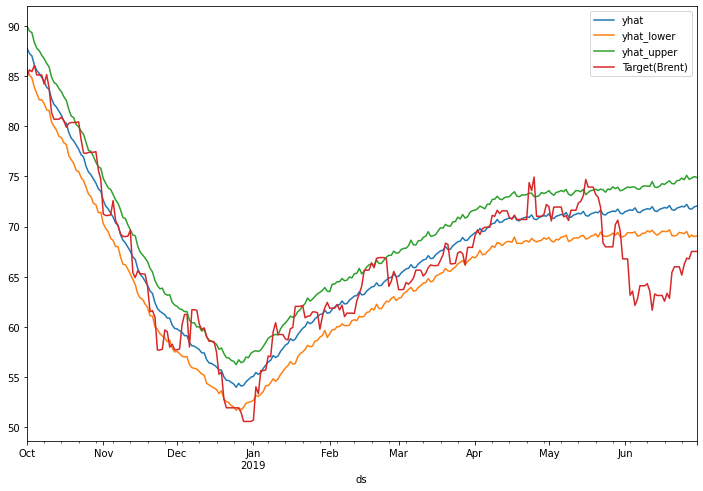

In [84]:
fcast.plot()
#again not a good result.ofc we will choose yhat for rmse calculation not yhat_lower to get lower rmse.

In [85]:
np.sqrt(mean_absolute_error(brent_test_daily["Target(Brent)"],fcast[["yhat"]].tail(30)))

2.668769913728954

In [86]:
results_df["fbprophet_linear"]=np.sqrt(mean_absolute_error(brent_test_daily["Target(Brent)"],fcast[["yhat"]].tail(30)))
results_df

,holt_winters_rmse,ar15_rmse,sarima0100117_rmse,sarimax0210007_scaled_rmse,sarimax0210007_stdscaled_rmse,fbprophet_linear
0,1.581061,1.427157,1.50819,1.498391,1.498419,2.66877


### Prophet Forecast Evaluation and Trend/Seasonality checkpoints for later if i have time.
trend checkpoints could help us see where trends are changed and we can maybe investigate it further and add more data
to our columns or if there are big changes we dont use all of the data for forecast but rather using data after that forecast, like stock crash or sth.

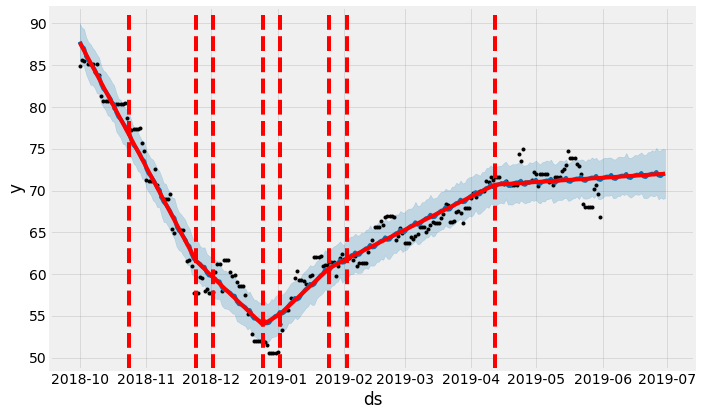

In [236]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

## Deep Learning Forecasting (Univariate and Multivariate approach)

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [88]:
#brent_train_daily_scaled.to_csv("brent_train_daily_scaled.csv")

In [89]:
#brent_test_daily_scaled.to_csv("brent_test_daily_scaled.csv")
#i will use this dset for automl timeseries purposes at the very end of the project, if i have time.

In [90]:
scaler=MinMaxScaler()
brent_train_daily_dlscaled=scaler.fit_transform(brent_train_daily[["Target(Brent)"]])
brent_test_daily_dlscaled=scaler.transform(brent_test_daily[["Target(Brent)"]])

In [106]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [107]:
# define generator
n_input = 35
n_features = 1
generator = TimeseriesGenerator(brent_train_daily_dlscaled, brent_train_daily_dlscaled, length=n_input, batch_size=1)

#basically, timeseriesgenerator make yr job easy in terms of making yr data elligible for keras rnn model.
#bcs its univariate n_features=1 however n_input should be tuned manually. if you have weekly seasonality, its at least
#7 for your daily data to manage to see that seasonality. generally, higher is better but needs more complex rnn architecture

#i will make it see couple seasonality, so 35 will be our first try. it could be good if u run a linspace for loop to
#test couple of them with respect to test set performance.

#batch_size=1 is like LOOCV, and 5 is 5FOLD CV. Higher batchsize generally gives lower performance but again u need to test
#this as well.

#i need to enter brent_train_daily_dlscaled twice bcs one is for data and other is for target. basically tsgenerator will
#create a dset format that make rnn use last 35 value to pred next value.

In [108]:
#check first batch. generator returns tuple thus we need tuple unpacking
X,y = generator[0]

In [109]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')
#rnn uses this 35 x value(they re 1st 35 val of brent_train_daily_dlscaled and pred 36th value of brent_train_daily_dlscaled)

Given the Array: 
[0.96816901 0.98760563 0.98253521 1.         0.97323944 0.97323944
 0.97323944 0.94788732 0.9743662  0.93661972 0.86704225 0.84901408
 0.84901408 0.84901408 0.85464789 0.84394366 0.82647887 0.83746479
 0.83971831 0.83971831 0.83971831 0.84169014 0.7915493  0.75408451
 0.75295775 0.75577465 0.75577465 0.75596244 0.75807512 0.70633803
 0.67944836 0.58237089 0.57859155 0.57859155 0.58043427]
Predict this y: 
 [[0.62042254]]


### Create univariate model

In [110]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

#bcs i have univaritate model, i dont need to use dropout regularization to get rid of unnecessary cols and bcs my dset is
#small i could add couple lstm layers. so it could be, 3 lstm input and output layer. 
#neuralnet models are blackbox, hard to interpret, and if u have strong computation power u can add too many layers until
#u overfit the training data.

In [111]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(n_input, n_features),return_sequences=True))
model.add(LSTM(150, activation='relu' ,return_sequences=True))
model.add(LSTM(150, activation='relu',return_sequences=True))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#tensorflow package issue. 
#AttributeError: module 'tensorflow.python.framework.ops' has no attribute '_TensorLike'
#i create another python environment, load dependencies and check again.

In [112]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 35, 150)           91200     
_________________________________________________________________
lstm_9 (LSTM)                (None, 35, 150)           180600    
_________________________________________________________________
lstm_10 (LSTM)               (None, 35, 150)           180600    
_________________________________________________________________
dense_1 (Dense)              (None, 35, 1)             151       
Total params: 452,551
Trainable params: 452,551
Non-trainable params: 0
_________________________________________________________________


In [113]:
model.fit_generator(generator,epochs=100)
#note: use early stopping, 200 epochs is too much. 1 forward propagation to get the value and 1 backward propagation to tune
#the weights with respect to your prediction error together is 1 epoch. 200 epoch takes around 10 min. it ll take too much
#time in multivariate case.

Epoch 1/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0368
Epoch 2/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0243
Epoch 3/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0218
Epoch 4/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0212
Epoch 5/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0189
Epoch 6/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0185
Epoch 7/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0172
Epoch 8/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0163
Epoch 9/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0151
Epoch 10/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0159
Epoch 11/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0140
Epoch 12/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0128
E

208/208 [==============================] - 3s 14ms/step - loss: 0.0028
Epoch 194/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0030
Epoch 195/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0027
Epoch 196/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0029
Epoch 197/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0031
Epoch 198/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0031
Epoch 199/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0030
Epoch 200/200
208/208 [==============================] - 3s 14ms/step - loss: 0.0030


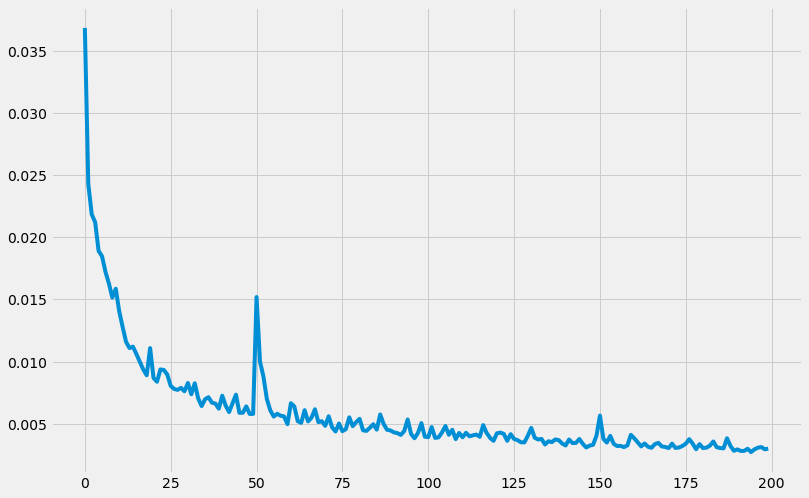

In [114]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

#we can stop around 25 or maybe 60. this is little bit overkill.

### Evaluate on Test Data

In [182]:
test_predictions = []

first_eval_batch = brent_train_daily_dlscaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(brent_test_daily_dlscaled)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0][34,0].reshape(1,)
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],current_pred.reshape(1,1,1),axis=1)
    
#this code block allows u to pred more than 1 future period. however problem with rnn is, if u pred very into the future
#essentially u ll predict/forecast using yr forecasted data. that will cause very noisy data.its not the case for us ofc
#we just pred for 1 month.

In [190]:
test_predictions=np.array(pd.DataFrame(test_predictions))

### Inverse Transformations and Compare

In [191]:
true_predictions = scaler.inverse_transform(test_predictions)
#we need to transform our data to calculate our evaluation metrics

In [192]:
brent_test_daily_dl=brent_test_daily_scaled[["Target(Brent)"]].copy()

In [193]:
# IGNORE WARNINGS
brent_test_daily_dl['Predictions_univariate'] = true_predictions

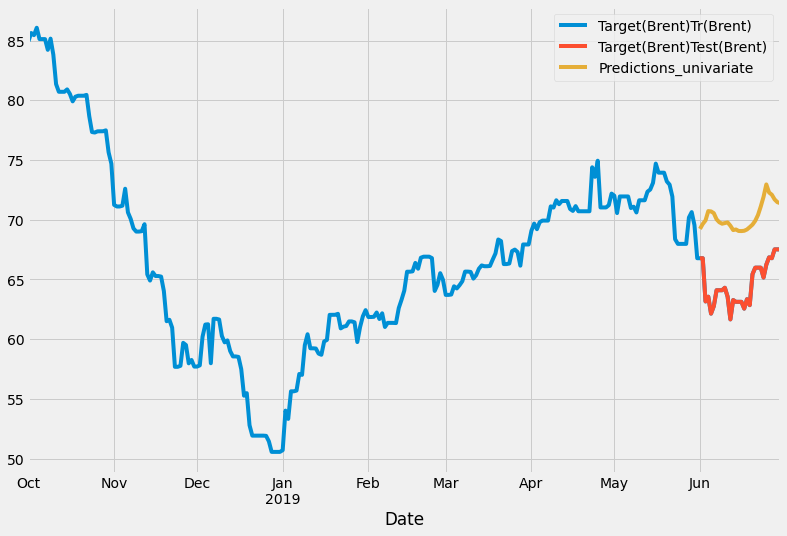

In [227]:
brent_df[["Target(Brent)"]].join(brent_test_daily_dl,lsuffix="Tr(Brent)",rsuffix="Test(Brent)").plot()

In [195]:
np.sqrt(mean_absolute_error(brent_test_daily_dl["Target(Brent)"],brent_test_daily_dl['Predictions_univariate']))

2.3717437183853414

In [196]:
results_df["dl_univariate_3lstm"]=np.sqrt(mean_absolute_error(brent_test_daily_dl["Target(Brent)"],
                                                              brent_test_daily_dl['Predictions_univariate']))
results_df

,holt_winters_rmse,ar15_rmse,sarima0100117_rmse,sarimax0210007_scaled_rmse,sarimax0210007_stdscaled_rmse,fbprophet_linear,dl_univariate_3lstm
0,1.581061,1.427157,1.50819,1.498391,1.498419,2.66877,2.371744


### Multivariate DeepLearning Model w RNN

In [ ]:
#multivariate deeplearning rnn models are hard to tune. Literally same code as RNN just using all cols. thats all.

In [279]:
scaler=MinMaxScaler()
brent_train_daily_dl2scaled=scaler.fit_transform(brent_train_daily)
brent_test_daily_dl2scaled=scaler.transform(brent_test_daily)

In [280]:
brent_train_daily_dl2scaled

array([[0.75400679, 0.69653521, 0.30591113, ..., 0.33296901, 0.70071507,
        0.96816901],
       [0.56457828, 0.58807833, 0.49853596, ..., 0.27664075, 0.5861235 ,
        0.98760563],
       [0.32365748, 0.57204284, 0.55387774, ..., 0.39017533, 0.44923883,
        0.98253521],
       ...,
       [0.55874187, 0.48054139, 0.44876987, ..., 0.40330424, 0.13772962,
        0.56535211],
       [0.30162275, 0.301508  , 0.82984619, ..., 0.83588889, 0.        ,
        0.53464789],
       [0.49911285, 0.4132533 , 0.46431897, ..., 0.78072905, 0.2126812 ,
        0.45661972]])

In [281]:
length = 30 # Length of the output sequences (in number of timesteps)
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(brent_train_daily_dl2scaled, brent_train_daily_dl2scaled,
                                length=length, batch_size=batch_size)

In [282]:
print(brent_train_daily_dl2scaled.shape)
print(brent_test_daily_dl2scaled.shape)

(243, 10)
(30, 10)


In [291]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(length,brent_train_daily_dl2scaled.shape[1]),return_sequences=True))
model.add(LSTM(150, activation='relu' ,return_sequences=True))
model.add(LSTM(150, activation='relu' ,return_sequences=True))
model.add(Dense(brent_train_daily_dl2scaled.shape[1]))
model.compile(optimizer='adam', loss='mse')

#to decrease time needed

In [292]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 30, 150)           96600     
_________________________________________________________________
lstm_30 (LSTM)               (None, 30, 150)           180600    
_________________________________________________________________
lstm_31 (LSTM)               (None, 30, 150)           180600    
_________________________________________________________________
dense_11 (Dense)             (None, 30, 10)            1510      
Total params: 459,310
Trainable params: 459,310
Non-trainable params: 0
_________________________________________________________________


In [293]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=1)
validation_generator = TimeseriesGenerator(brent_test_daily_dl2scaled,brent_test_daily_dl2scaled, 
                                           length=length, batch_size=batch_size,start_index=0,end_index=30)

In [295]:
model.fit_generator(generator,epochs=150)

Epoch 1/150
213/213 [==============================] - 3s 16ms/step - loss: 0.0388
Epoch 2/150
213/213 [==============================] - 3s 16ms/step - loss: 0.0381
Epoch 3/150
213/213 [==============================] - 3s 16ms/step - loss: 0.0371
Epoch 4/150
213/213 [==============================] - 4s 18ms/step - loss: 0.0370
Epoch 5/150
213/213 [==============================] - 4s 18ms/step - loss: 0.0362
Epoch 6/150
213/213 [==============================] - 4s 17ms/step - loss: 0.0363
Epoch 7/150
213/213 [==============================] - 4s 16ms/step - loss: 0.0348
Epoch 8/150
213/213 [==============================] - 4s 17ms/step - loss: 0.0353: 0
Epoch 9/150
213/213 [==============================] - 3s 16ms/step - loss: 0.0342
Epoch 10/150
213/213 [==============================] - 4s 17ms/step - loss: 0.0342
Epoch 11/150
213/213 [==============================] - 3s 16ms/step - loss: 0.0409
Epoch 12/150
213/213 [==============================] - 3s 16ms/step - loss: 0.782

213/213 [==============================] - 4s 17ms/step - loss: 0.0149
Epoch 99/150
213/213 [==============================] - 4s 17ms/step - loss: 0.0136
Epoch 100/150
213/213 [==============================] - 3s 16ms/step - loss: 0.0145
Epoch 101/150
213/213 [==============================] - 3s 16ms/step - loss: 0.0144: 0s -
Epoch 102/150
213/213 [==============================] - 4s 18ms/step - loss: 0.1897
Epoch 103/150
213/213 [==============================] - 4s 18ms/step - loss: 0.0365
Epoch 104/150
213/213 [==============================] - 3s 16ms/step - loss: 0.0322
Epoch 105/150
213/213 [==============================] - 4s 17ms/step - loss: 0.0300
Epoch 106/150
213/213 [==============================] - 3s 16ms/step - loss: 0.0272
Epoch 107/150
213/213 [==============================] - 3s 16ms/step - loss: 0.0255
Epoch 108/150
213/213 [==============================] - 4s 16ms/step - loss: 0.0242
Epoch 109/150
213/213 [==============================] - 3s 16ms/step - lo

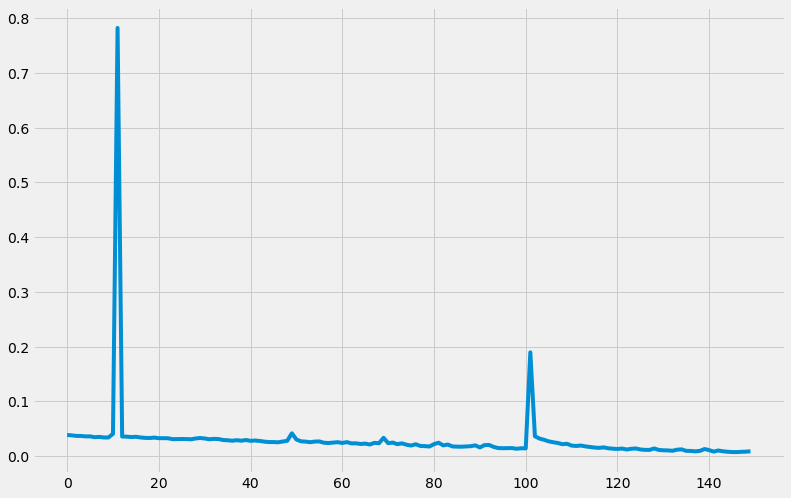

In [296]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [341]:
n_features = brent_train_daily_dl2scaled.shape[1]
test_predictions = []

first_eval_batch = brent_train_daily_dl2scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(brent_train_daily_dl2scaled)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0][29,:]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [342]:
test_predictions=np.array(pd.DataFrame(test_predictions[0:30]))

In [343]:
true_predictions = scaler.inverse_transform(test_predictions)
#we need to transform our data to calculate our evaluation metrics

In [349]:
true_predictions=pd.DataFrame(true_predictions).iloc[:,9]

In [350]:
brent_test_daily_dl2=brent_test_daily_scaled[["Target(Brent)"]].copy()

In [359]:
true_predictions.index=brent_test_daily_dl2.index

In [360]:
# IGNORE WARNINGS
brent_test_daily_dl2['Predictions_multivariate'] = true_predictions

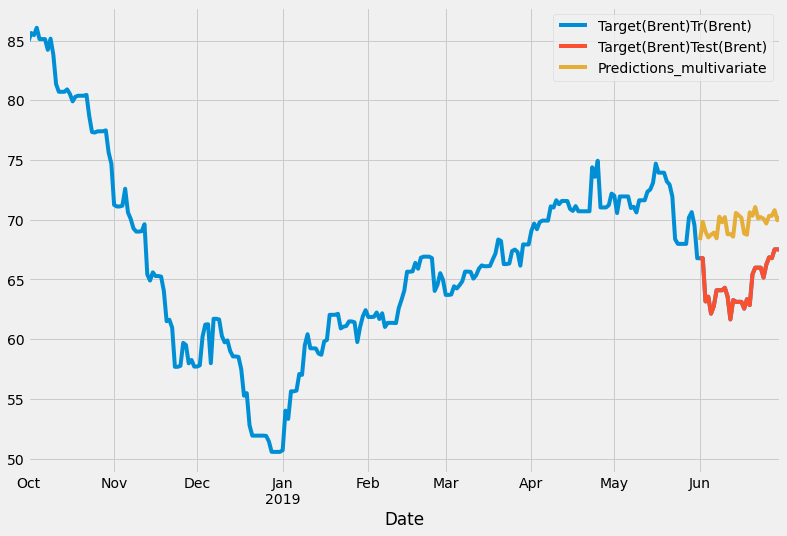

In [362]:
brent_df[["Target(Brent)"]].join(brent_test_daily_dl2,lsuffix="Tr(Brent)",rsuffix="Test(Brent)").plot()


In [363]:
np.sqrt(mean_absolute_error(brent_test_daily_dl["Target(Brent)"],brent_test_daily_dl2['Predictions_multivariate']))

2.24542742010132

In [365]:
results_df["dl_multivariate_3lstm"]=np.sqrt(mean_absolute_error(brent_test_daily_dl["Target(Brent)"],
                                                                brent_test_daily_dl2['Predictions_multivariate']))
results_df

,holt_winters_rmse,ar15_rmse,sarima0100117_rmse,sarimax0210007_scaled_rmse,sarimax0210007_stdscaled_rmse,fbprophet_linear,dl_univariate_3lstm,dl_multivariate_3lstm
0,1.581061,1.427157,1.50819,1.498391,1.498419,2.66877,2.371744,2.245427


### SHORT AUTOML APPROACH TO TIMESERIES (EXTRA)

<img src="dai_img1.png">

<img src="dai_img2.png">

In [367]:
h2o_automl_test_pred=pd.read_csv("h2oai_experiment_gipokoho_test_predictions.csv").iloc[:,[0,1]]

In [376]:
h2o_automl_test_pred.index=brent_test_daily_dl2.index

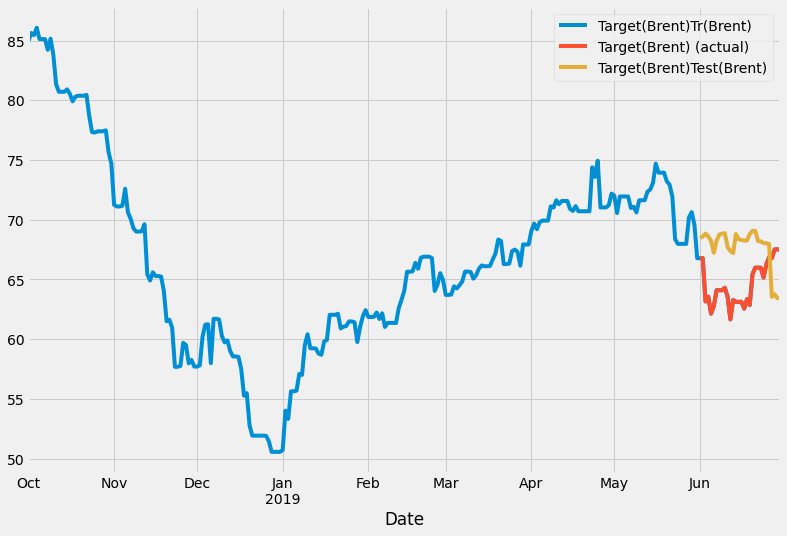

In [378]:
brent_df[["Target(Brent)"]].join(h2o_automl_test_pred,lsuffix="Tr(Brent)",rsuffix="Test(Brent)").plot()


In [370]:
np.sqrt(mean_absolute_error(brent_test_daily_dl["Target(Brent)"],h2o_automl_test_pred.iloc[:,1]))

2.0122567077542617

In [371]:
results_df["h2o_automl_991"]=np.sqrt(mean_absolute_error(brent_test_daily_dl["Target(Brent)"],
                                                         h2o_automl_test_pred.iloc[:,1]))
results_df

,holt_winters_rmse,ar15_rmse,sarima0100117_rmse,sarimax0210007_scaled_rmse,sarimax0210007_stdscaled_rmse,fbprophet_linear,dl_univariate_3lstm,dl_multivariate_3lstm,h2o_automl_991
0,1.581061,1.427157,1.50819,1.498391,1.498419,2.66877,2.371744,2.245427,2.012257


### HOW AUTOML WORKS

1)use gcp and create virtual machine in the cloud
2)set SSH and firewall settings 
3)app uses feature engineering and different model stackings to calculate ts data:

-Fengineering from timestamp(day,month,y,weekday,weeknum,isholiday)

-Fengineering from target:
* lag features (lag1,lag2 etc)
* moving average (smoother time, model recognize more general pattern)
* ewma of nth order
* aggregation of lags(groupby and lag mean,sum,std)
* lag interaction (lag1-lag2 etc)
* linear regression on lags (uses slope and intercept of lagged col as feature, not sure how)

* and many others

* i will add logs of automl if you are interested , i couldnt tune automl completely, u have many things to tune in app. nonetheless it gives rmse value of 2

In [384]:
# Feature engineering icin yeterli zaman kalmadı maalesef. ama genel olarak timeseries data icin automl in yukarıda
# belirttigim feature engineering yaklasımlarını kullanmaya calısacaktım.

# ornegin bir dukkanın musteri tahminini yaparken holiday kolonunun musteri sayısı kolonuyla korelasyon icinde oldugu gorulur
# se isholiday kolonu eklenmesi dusunebilir. yani bu yaklasımlar her kolona uygulanmaz biraz algısal olarak kafaya yatması 
# gerekir cogu zamanda deneyimle ezberlenen yontemlerdir bunlar

# genel yaklasım olarak konustugumuz icin genel olarak bir timeseries konuları aktarımı gibi yapmaya calıstım her cesit 
# timeseries ile ilgilenebilecegimiz icin belli baslı modellerin bir kısmını aktardım (var,varmax,arch yetismedi) her modeli
# niye kullandıgımı belli olculerde aktardım altına yorum olarak ya da markdown olarak da. proje bu haliyle yarım sayılır,
# modeller genel olarak base modeller, bunların uzerinden basarılı olanlar secilip feature engineering uzerine calısmak
# gerekiyor. bu benim bu kadar uzun ilk ts projem, kendimi kısa zamanda gelistirebileceğimi düsünüyorum.

# incelemeniz icin tesekkür ederim, gorusmek uzere.
# berkay akin -5350853609

Bazı Kaynaklar

https://people.duke.edu/~rnau/411arim3.htm   - manual ar vs ma

https://otexts.com/fpp2/arima-r.html         - arima procedure. auto arima or other path.

https://peerj.com/preprints/3190.pdf         - about facebook prophet pdf 25 pages.

https://robjhyndman.com/hyndsight/seasonal-periods/   - how to choose m.

https://alkaline-ml.com/pmdarima/tips_and_tricks.html   - pmdarima


https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series

https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru